# Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Set a seed for reproducibility
random.seed(42)

# Paths to the data directories
features_dir = '/kaggle/input/cloud-cover-detection/data/train_features'
labels_dir = '/kaggle/input/cloud-cover-detection/data/train_labels'

# Get the list of feature directories (each directory contains multiple bands as .tif files)
feature_subdirs = os.listdir(features_dir)
label_files = os.listdir(labels_dir)

# Only keep matching features and labels
matching_files = [f for f in feature_subdirs if f + ".tif" in label_files]

# Shuffle and take 10% of the matching data
sample_size = int(len(matching_files) * 0.1)
selected_files = random.sample(matching_files, sample_size)

train_images = []
train_labels = []

# Function to load a .tif image from a given path
def load_tif_image(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)  # Read the first band (for simplicity)

# Load the selected features and labels
for file_name in selected_files:
    # Load features (e.g., B02, B03, B04 bands)
    b02_path = os.path.join(features_dir, file_name, "B02.tif")
    b03_path = os.path.join(features_dir, file_name, "B03.tif")
    b04_path = os.path.join(features_dir, file_name, "B04.tif")

    # Load bands and stack them
    b02 = load_tif_image(b02_path)
    b03 = load_tif_image(b03_path)
    b04 = load_tif_image(b04_path)

    # Stack the bands along the last axis to form a 3-channel image
    image = np.stack([b02, b03, b04], axis=-1)
    train_images.append(image)

    # Load the corresponding label
    label_path = os.path.join(labels_dir, file_name + ".tif")
    label = load_tif_image(label_path)
    train_labels.append(label)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Selected 10% of Images: {train_images.shape}")
print(f"Selected 10% of Labels: {train_labels.shape}")


Selected 10% of Images: (1174, 512, 512, 3)
Selected 10% of Labels: (1174, 512, 512)


In [4]:
import numpy as np
import tensorflow as tf

# Print original shapes
print("Original train_images shape:", train_images.shape)
print("Original train_labels shape:", train_labels.shape)

# Add channel dimension to masks
if len(train_labels.shape) == 3:  # (batch_size, height, width)
    train_labels = np.expand_dims(train_labels, axis=-1)  # Shape will be (batch_size, height, width, 1)

# Resize images (RGB)
IMG_SIZE = 256  # Resize to a smaller image to reduce computation
train_images_resized = np.array([tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) for img in train_images])

# Resize masks (greyscale) with nearest neighbor interpolation
train_labels_resized = np.array([tf.image.resize(label, (IMG_SIZE, IMG_SIZE), method='nearest') for label in train_labels])

# Normalize images
train_images_resized = train_images_resized / 255.0

# Print new shapes
print("Resized train_images shape:", train_images_resized.shape)
print("Resized train_labels shape:", train_labels_resized.shape)


Original train_images shape: (1174, 512, 512, 3)
Original train_labels shape: (1174, 512, 512)
Resized train_images shape: (1174, 256, 256, 3)
Resized train_labels shape: (1174, 256, 256, 1)


In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images_resized, train_labels_resized, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (939, 256, 256, 3)
Validation set size: (235, 256, 256, 3)


In [6]:
# Function to create a TensorFlow dataset
def create_dataset(images, masks, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

# Create training and validation datasets
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)


Training set size: (939, 256, 256, 3)
Validation set size: (235, 256, 256, 3)


# Loss Function and Evaluation Metric

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return dice + bce

def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

# Model Building

## Basic cnn

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D, Concatenate

def build_cnn_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Bottleneck
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Upsampling Path
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    # Final Convolutional Layer for pixel-wise classification
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # Output shape will be (IMG_SIZE, IMG_SIZE, 1)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=combined_loss, metrics=[iou_metric])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "functional_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_77 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_660 (Conv2D)             │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_182               │ (None, 128, 128, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_639         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_661 (Conv2D)             │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_183               │ (None, 64, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_640         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_662 (Conv2D)             │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_184               │ (None, 32, 32, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_641         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_663 (Conv2D)             │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_664 (Conv2D)             │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_665 (Conv2D)             │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_666 (Conv2D)             │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_667 (Conv2D)             │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 776,641 (2.96 MB)

 Trainable params: 776,193 (2.96 MB)

 Non-trainable params: 448 (1.75 KB)

In [148]:
history = cnn_model.fit(
        train_dataset,
    validation_data=val_dataset,
    epochs=40,
    verbose=2
)

Epoch 1/40
30/30 - 27s - 908ms/step - iou_metric: 0.6568 - loss: 0.8562 - val_iou_metric: 0.6751 - val_loss: 1.0276
Epoch 2/40
30/30 - 2s - 63ms/step - iou_metric: 0.7025 - loss: 0.6349 - val_iou_metric: 0.6292 - val_loss: 0.7108
Epoch 3/40
30/30 - 2s - 63ms/step - iou_metric: 0.7128 - loss: 0.5417 - val_iou_metric: 0.6138 - val_loss: 0.6936
Epoch 4/40
30/30 - 2s - 63ms/step - iou_metric: 0.7250 - loss: 0.5165 - val_iou_metric: 0.6323 - val_loss: 0.6817
Epoch 5/40
30/30 - 3s - 84ms/step - iou_metric: 0.7308 - loss: 0.5090 - val_iou_metric: 0.6439 - val_loss: 0.6262
Epoch 6/40
30/30 - 2s - 63ms/step - iou_metric: 0.7295 - loss: 0.5084 - val_iou_metric: 0.6612 - val_loss: 0.5813
Epoch 7/40
30/30 - 2s - 63ms/step - iou_metric: 0.7391 - loss: 0.4878 - val_iou_metric: 0.6899 - val_loss: 0.5190
Epoch 8/40
30/30 - 2s - 62ms/step - iou_metric: 0.7467 - loss: 0.4729 - val_iou_metric: 0.6994 - val_loss: 0.5041
Epoch 9/40
30/30 - 2s - 63ms/step - iou_metric: 0.7434 - loss: 0.4790 - val_iou_metric

In [165]:
# Save the trained model
print('Saving the trained model...')
cnn_model.save('models/cnn_cloud_detection1.h5')

Saving the trained model...


In [166]:
# Evaluate the model on validation set
val_preds = cnn_model.predict(X_val)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Shape of y_val:", y_val.shape)
print("Shape of val_preds:", val_preds.shape)

# Flatten arrays to 1D
y_val_flat = y_val.flatten()
val_preds_flat = val_preds.flatten()

# Compute accuracy
accuracy = accuracy_score(y_val_flat, val_preds_flat)
print("Accuracy on Validation set:", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shape of y_val: (235, 256, 256, 1)
Shape of val_preds: (235, 256, 256, 1)
Accuracy on Validation set: 0.8815831610497008


## unet

In [7]:
#unet
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam


def unet(output_layer=1):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

model = unet()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_4[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [162]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Compile U-Net model
model.compile(optimizer=tf.keras.optimizers.AdamW(1e-3), 
                   loss=combined_loss, 
                   metrics=[iou_metric])
    
# Train U-Net on your segmentation task
history = model.fit(train_dataset,
    validation_data=val_dataset, epochs=30, callbacks=[reduce_lr])


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - iou_metric: 0.5821 - loss: 0.8021 - val_iou_metric: 0.0050 - val_loss: 10.7377 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.6759 - loss: 0.5977 - val_iou_metric: 0.1230 - val_loss: 8.1274 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.6927 - loss: 0.5615 - val_iou_metric: 0.4134 - val_loss: 2.1795 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.7060 - loss: 0.5384 - val_iou_metric: 0.5928 - val_loss: 1.0075 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.7142 - loss: 0.5270 - val_iou_metric: 0.4628 - val_loss: 2.9231 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.7219 - loss: 0.5059 - val_iou_metric: 0.6411 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric:

In [163]:
# Evaluate the model on validation set
val_preds = model.predict(X_val)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Shape of y_val:", y_val.shape)
print("Shape of val_preds:", val_preds.shape)

# Flatten arrays to 1D
y_val_flat = y_val.flatten()
val_preds_flat = val_preds.flatten()

# Compute accuracy
accuracy = accuracy_score(y_val_flat, val_preds_flat)
print("Accuracy on Validation set:", accuracy)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
Shape of y_val: (235, 256, 256, 1)
Shape of val_preds: (235, 256, 256, 1)
Accuracy on Validation set: 0.888127753075133


## Self Supervised Contrastive Learning

In [139]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Model

IMG_SIZE = 128

def unet_encoder():
    """ Define your U-Net encoder without the decoder """
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)
      # Output feature embedding
    flattened = tf.keras.layers.GlobalAveragePooling2D()(conv4) # Use global pooling to get feature vectors
    
    model = Model(inputs, flattened)
    return model

def projection_head(encoder_output, units=128):
    x = encoder_output
    x = tf.keras.layers.Dense(units, activation='relu')(x)  # Fully connected layer
    x = tf.keras.layers.BatchNormalization()(x)  # Normalize embeddings
    x = tf.keras.layers.Dense(units)(x)  # Final embedding layer
    return x

def create_simclr_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    encoder = unet_encoder()
    features = encoder(inputs)
    projection = projection_head(features)
    
    model = Model(inputs, projection)
    return model

def contrastive_loss_fn(temperature=0.1):
    def loss(y_true, y_pred):
        # Normalize the embeddings
        y_pred = tf.math.l2_normalize(y_pred, axis=1)
        
        # Compute similarity matrix
        similarity_matrix = tf.matmul(y_pred, y_pred, transpose_b=True)
        
        # Extract positives and negatives
        batch_size = tf.shape(y_pred)[0]
        mask = tf.eye(batch_size)
        positives = tf.boolean_mask(similarity_matrix, mask)
        
        # Compute logits by scaling by temperature
        logits = similarity_matrix / temperature
        
        # Exclude positive samples for negative sampling
        logits_mask = 1 - mask
        negatives = tf.boolean_mask(logits, logits_mask)
        
        # Compute contrastive loss (cross-entropy)
        labels = tf.range(batch_size)
        contrastive_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Apply the loss
        loss = contrastive_loss(labels, logits)
        return loss
    
    return loss

# Compile SimCLR model
simclr_model = create_simclr_model()
simclr_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=contrastive_loss_fn())

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(32)

# Train SimCLR
simclr_model.fit(train_dataset, epochs=15, batch_size=32)



Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - loss: 0.0924
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0261
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0151
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0114
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0078
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0058
Epoch 9/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0047
Epoch 10/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043
Epoch 11/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0044
Epoch 12/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036
Epoch 13/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 14/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 15/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035


In [152]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


# After training SimCLR
unet_model = unet()  # Initialize U-Net model

# Load encoder weights from SimCLR model
simclr_layers = [layer for layer in simclr_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
unet_layers = [layer for layer in unet_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

for simclr_layer, unet_layer in zip(simclr_layers[:15], unet_layers[:15]):
    unet_layer.set_weights(simclr_layer.get_weights())
    unet_layer.trainable = False  # Freeze the layer


# Compile U-Net model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                   loss=combined_loss, 
                   metrics=[iou_metric])

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)

    
# Train U-Net on your segmentation task
unet_model.fit(train_dataset,
    validation_data=val_dataset, epochs=30, callbacks=[reduce_lr])


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - iou_metric: 0.5346 - loss: 0.8944 - val_iou_metric: 0.0378 - val_loss: 10.1215 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.6862 - loss: 0.5904 - val_iou_metric: 0.4307 - val_loss: 2.6926 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.6969 - loss: 0.5497 - val_iou_metric: 0.7010 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.7025 - loss: 0.5413 - val_iou_metric: 0.6949 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric: 0.7105 - loss: 0.5222 - val_iou_metric: 0.6661 - val_loss: 0.8657 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - iou_metric: 0.7198 - loss: 0.5088 - val_iou_metric: 0.6361 - val_loss: 1.2560 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - iou_metric:

In [153]:
# Evaluate the model on validation set
val_preds = unet_model.predict(X_val)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Shape of y_val:", y_val.shape)
print("Shape of val_preds:", val_preds.shape)

# Flatten arrays to 1D
y_val_flat = y_val.flatten()
val_preds_flat = val_preds.flatten()

# Compute accuracy
accuracy = accuracy_score(y_val_flat, val_preds_flat)
print("Accuracy on Validation set:", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step
Shape of y_val: (235, 256, 256, 1)
Shape of val_preds: (235, 256, 256, 1)
Accuracy on Validation set: 0.8855627830992354


In [154]:
# Save the trained model
print('Saving the trained model...')
unet_model.save('models/unet_ss_cloud_detection3.h5')

Saving the trained model...


## Self supervised with Data Augmentation

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Model

IMG_SIZE = 256

def unet_encoder():
    """ Define your U-Net encoder without the decoder """
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)
      # Output feature embedding
    flattened = tf.keras.layers.GlobalAveragePooling2D()(conv4) # Use global pooling to get feature vectors
    
    model = Model(inputs, flattened)
    return model

def projection_head(encoder_output, units=128):
    x = encoder_output
    x = tf.keras.layers.Dense(units, activation='relu')(x)  # Fully connected layer
    x = tf.keras.layers.BatchNormalization()(x)  # Normalize embeddings
    x = tf.keras.layers.Dense(units)(x)  # Final embedding layer
    return x

def create_simclr_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    encoder = unet_encoder()
    features = encoder(inputs)
    projection = projection_head(features)
    
    model = Model(inputs, projection)
    return model

def contrastive_loss_fn(temperature=0.1):
    def loss(y_true, y_pred):
        # Normalize the embeddings
        y_pred = tf.math.l2_normalize(y_pred, axis=1)
        
        # Compute similarity matrix
        similarity_matrix = tf.matmul(y_pred, y_pred, transpose_b=True)
        
        # Extract positives and negatives
        batch_size = tf.shape(y_pred)[0]
        mask = tf.eye(batch_size)
        positives = tf.boolean_mask(similarity_matrix, mask)
        
        # Compute logits by scaling by temperature
        logits = similarity_matrix / temperature
        
        # Exclude positive samples for negative sampling
        logits_mask = 1 - mask
        negatives = tf.boolean_mask(logits, logits_mask)
        
        # Compute contrastive loss (cross-entropy)
        labels = tf.range(batch_size)
        contrastive_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Apply the loss
        loss = contrastive_loss(labels, logits)
        return loss
    
    return loss

# Compile SimCLR model
simclr_model = create_simclr_model()
simclr_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=contrastive_loss_fn())

import tensorflow as tf

# Function to apply augmentations
def simclr_augmentations(image):
    # Randomly crop the image to 85% of its size, then resize back to original size
    image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.85), int(IMG_SIZE * 0.85), 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    # Random saturation adjustment
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Add random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    # Clip the values to [0, 1] to keep the image valid
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image


# Function to create pairs of augmented images
def create_pairs(image):
    # Apply augmentation twice to the same image
    aug1 = simclr_augmentations(image)
    aug2 = simclr_augmentations(image)
    
    return aug1, aug2

# Function to apply augmentations to a dataset and create pairs
def augment_dataset(X_train):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    
    # Create pairs of augmented images
    dataset = dataset.map(lambda x: create_pairs(x), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch the dataset
    dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Use augmented dataset in SimCLR training
train_dataset = augment_dataset(X_train)



# Train SimCLR
simclr_model.fit(train_dataset, epochs=15, batch_size=64)



NameError: name 'X_train' is not defined

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)


# After training SimCLR
unet_model = unet()  # Initialize U-Net model

# Load encoder weights from SimCLR model
simclr_layers = [layer for layer in simclr_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
unet_layers = [layer for layer in unet_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

for simclr_layer, unet_layer in zip(simclr_layers[:15], unet_layers[:15]):
    unet_layer.set_weights(simclr_layer.get_weights())
    unet_layer.trainable = False  # Freeze the layer


# Compile U-Net model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                   loss=combined_loss, 
                   metrics=[iou_metric])

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)

    
# Train U-Net on your segmentation task
unet_model.fit(train_dataset,
    validation_data=val_dataset, epochs=30, callbacks=[reduce_lr])


Epoch 1/30


2024-09-16 19:46:16.789176: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,16,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-16 19:46:17.028713: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.239663796s
Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,16,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - iou_metric: 0.5457 - loss: 0.8813 - val_iou_metric: 0.0218 - val_loss: 49.7824 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - iou_metric: 0.6742 - loss: 0.6065 - val_iou_metric: 0.1175 - val_loss: 12.4865 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - iou_metric: 0.6887 - loss: 0.5651 - val_iou_metric: 0.3557 - val_loss: 1.9978 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - iou_metric: 0.7017 - loss: 0.5431 - val_iou_metric: 0.7188 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - iou_metric: 0.7146 - loss: 0.5218 - val_iou_metric: 0.6212 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - iou_metric: 0.7105 - loss: 0.5340 - val_iou_metric: 0.6836 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - iou_metric: 0.7113 - 

In [14]:
# Evaluate the model on validation set
val_preds = unet_model.predict(X_val)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Shape of y_val:", y_val.shape)
print("Shape of val_preds:", val_preds.shape)

# Flatten arrays to 1D
y_val_flat = y_val.flatten()
val_preds_flat = val_preds.flatten()

# Compute accuracy
accuracy = accuracy_score(y_val_flat, val_preds_flat)
print("Accuracy on Validation set:", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step
Shape of y_val: (235, 256, 256, 1)
Shape of val_preds: (235, 256, 256, 1)
Accuracy on Validation set: 0.8870073683718418


# Results 
### 0.86 on original data

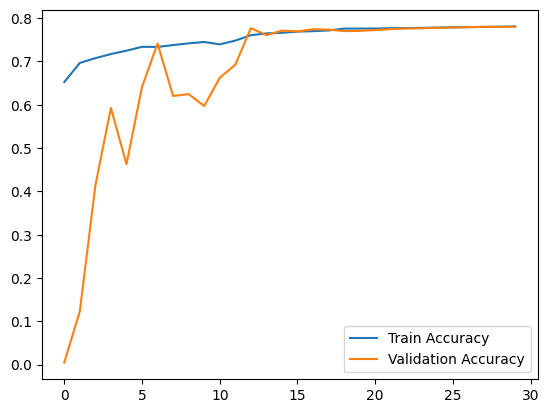

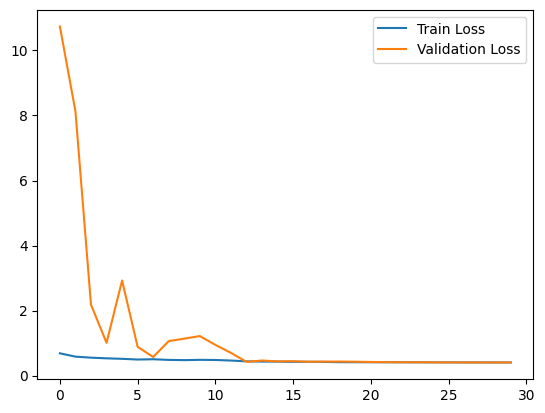

In [164]:
# Plot training and validation accuracy/loss
plt.plot(history.history['iou_metric'], label='Train Accuracy')
plt.plot(history.history['val_iou_metric'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Loading saved models...
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model 1 - Accuracy: 0.9178, IoU: 0.8324
Model 2 - Accuracy: 0.9175, IoU: 0.8488


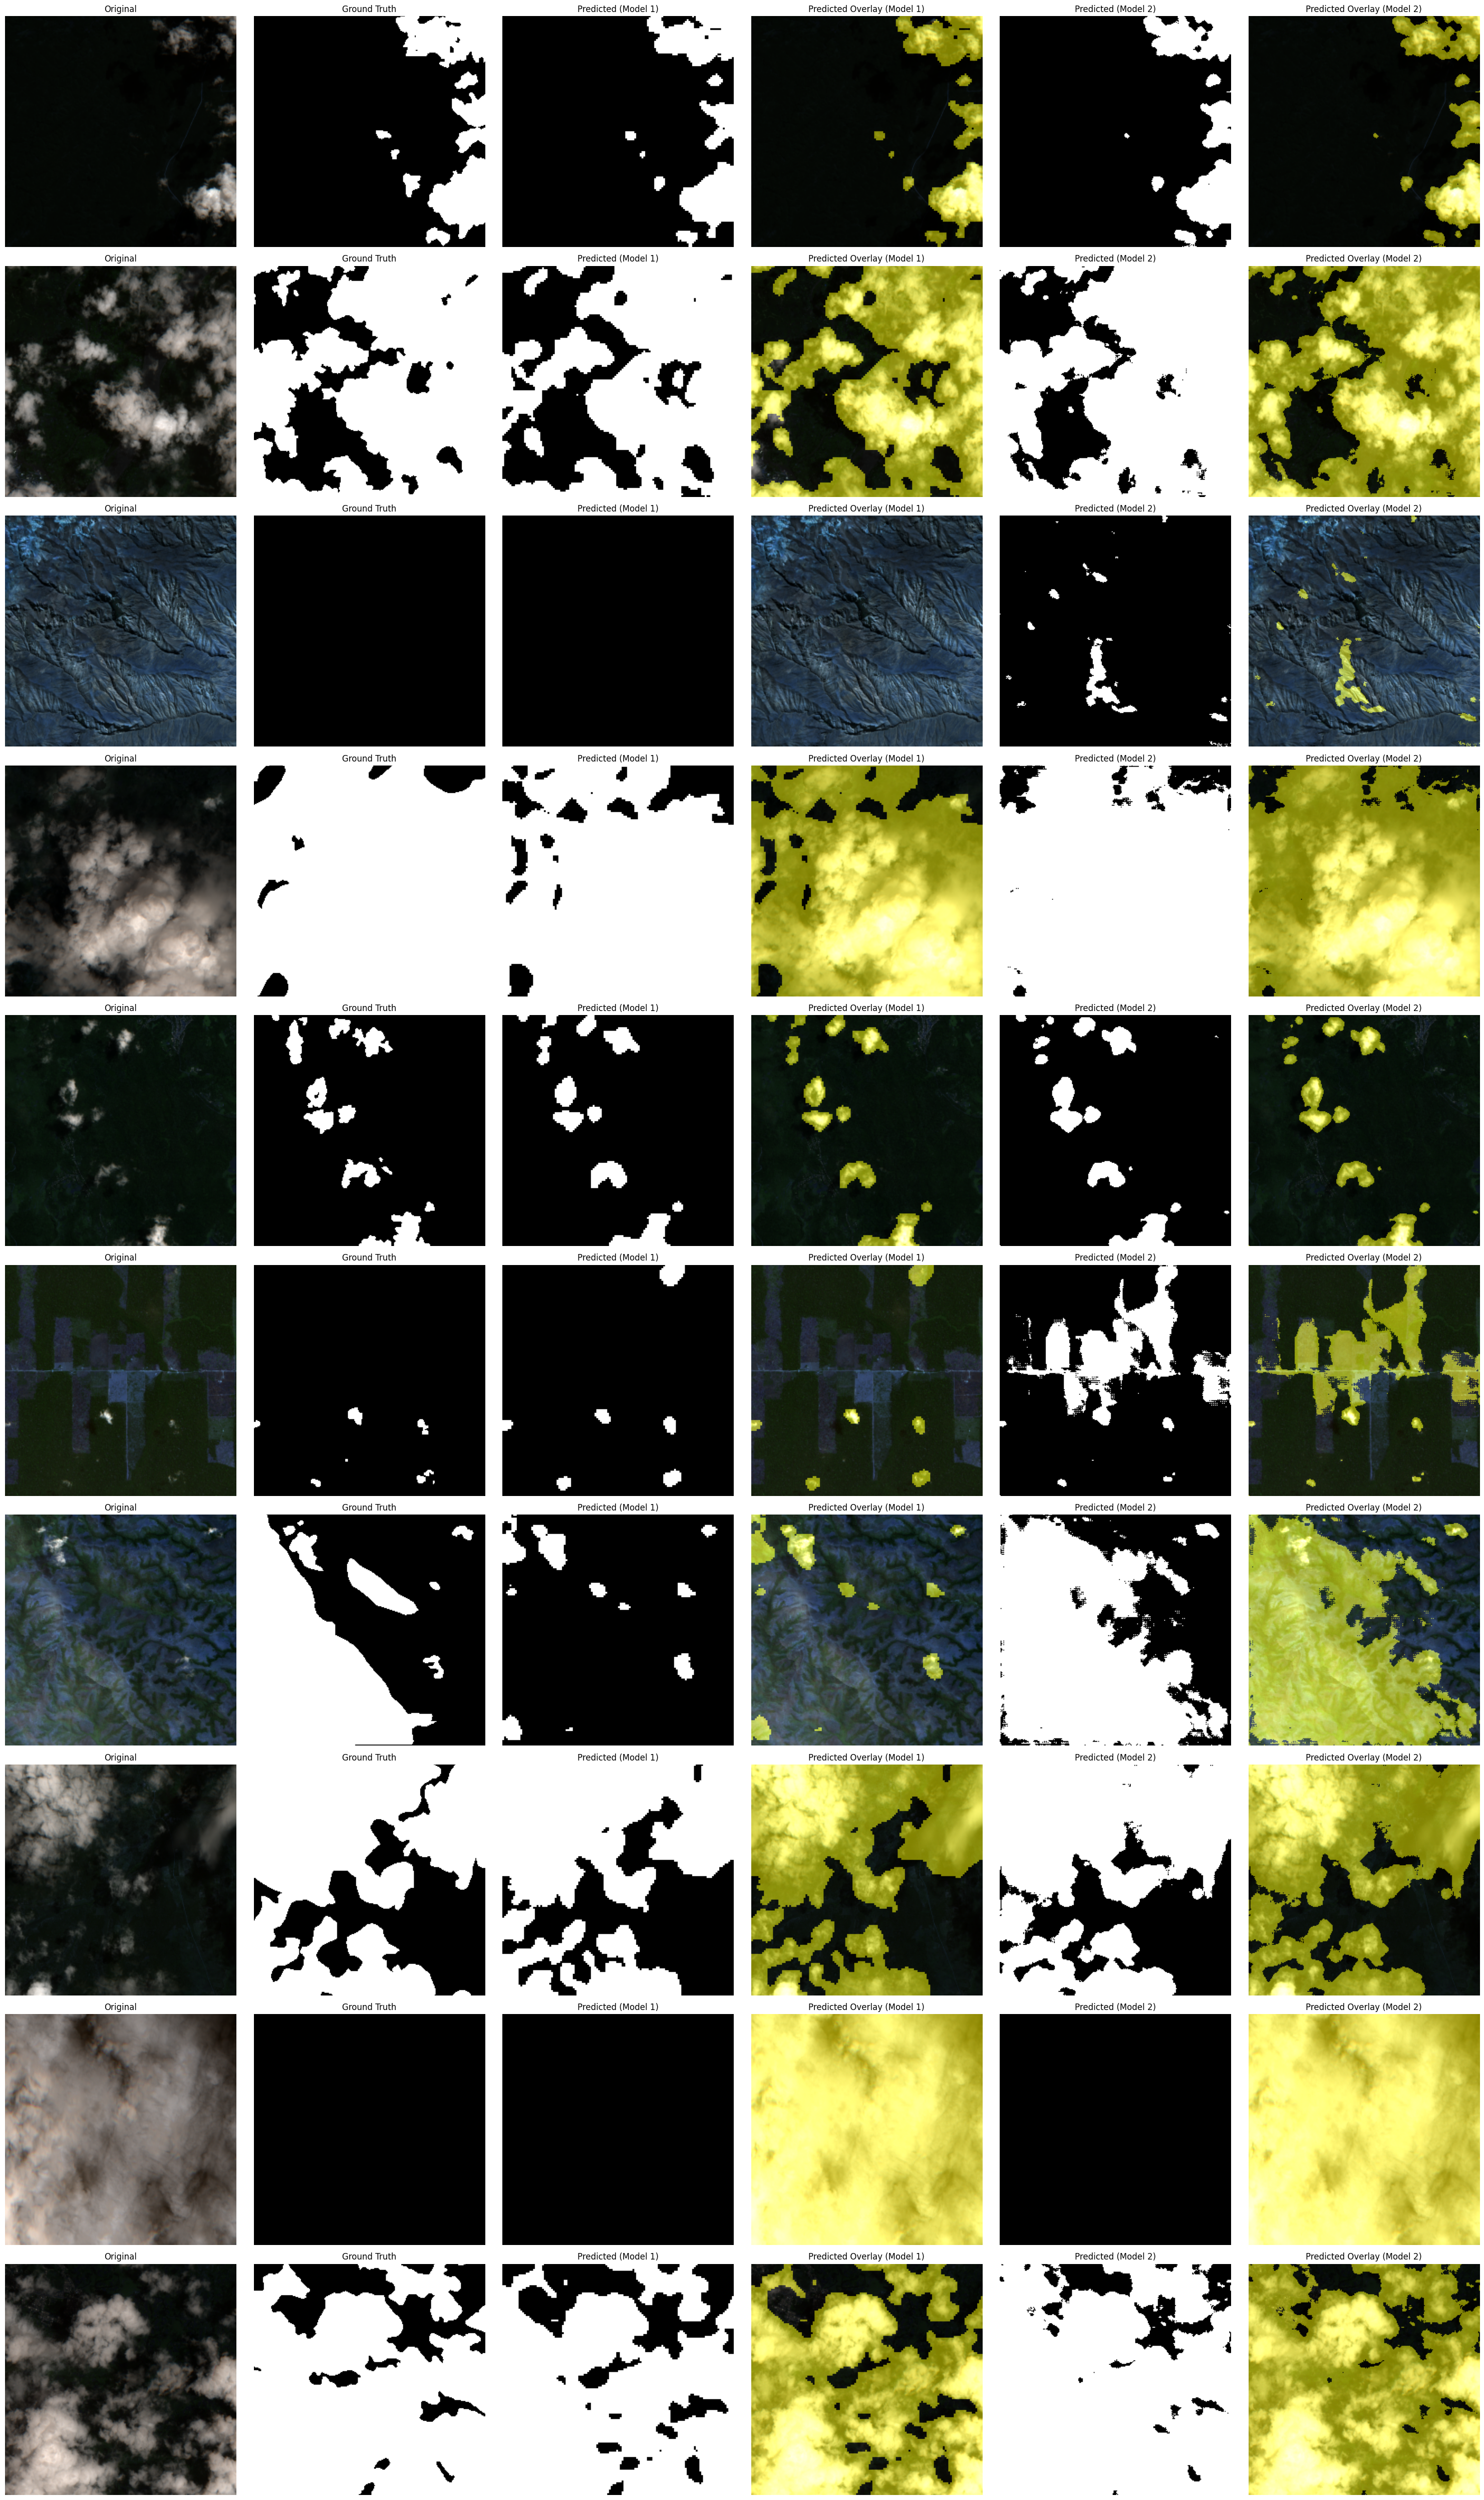

In [159]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import accuracy_score

random.seed(40)

# Load models
print('Loading saved models...')
cnn_model_1 = load_model('models/cnn_cloud_detection1.h5', custom_objects={'combined_loss': combined_loss, 'iou_metric': iou_metric})
cnn_model_2 = load_model('models/unet_ss_cloud_detection3.h5', custom_objects={'combined_loss': combined_loss, 'iou_metric': iou_metric})

# Predict and visualize 10 random predictions from the test set
print('Making predictions...')
random_indices = random.sample(range(0, len(X_val)), 10)
test_sample = X_val[random_indices]
ground_truths = y_val[random_indices]

predictions_1 = cnn_model_1.predict(test_sample)
predictions_1 = (predictions_1 > 0.5).astype(np.uint8)

predictions_2 = cnn_model_2.predict(test_sample)
predictions_2 = (predictions_2 > 0.5).astype(np.uint8)

# Calculate accuracy and IoU for both models
accuracy_1 = accuracy_score(ground_truths.flatten(), predictions_1.flatten())
accuracy_2 = accuracy_score(ground_truths.flatten(), predictions_2.flatten())

iou_1 = iou_metric(ground_truths, predictions_1).numpy()
iou_2 = iou_metric(ground_truths, predictions_2).numpy()

print(f'Model 1 - Accuracy: {accuracy_1:.4f}, IoU: {iou_1:.4f}')
print(f'Model 2 - Accuracy: {accuracy_2:.4f}, IoU: {iou_2:.4f}')

fig, axes = plt.subplots(10, 6, figsize=(30, 5*10))

for i in range(len(test_sample)):
    image = test_sample[i]
    image_normalized = (image - image.min()) / (image.max() - image.min())
    image = (image_normalized * 255).astype(np.uint8)
    
    mask_1 = predictions_1[i].squeeze()
    mask_2 = predictions_2[i].squeeze()
    ground_truth = ground_truths[i].squeeze()
    
    # Create yellow masks
    yellow_mask_1 = np.zeros_like(image)
    yellow_mask_1[mask_1 == 1] = [255, 255, 0]
    
    yellow_mask_2 = np.zeros_like(image)
    yellow_mask_2[mask_2 == 1] = [255, 255, 0]
    
    # Create overlays
    overlay_1 = cv2.addWeighted(image, 1, yellow_mask_1, 0.5, 0)
    overlay_2 = cv2.addWeighted(image, 1, yellow_mask_2, 0.5, 0)
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(mask_1, cmap='gray')
    axes[i, 2].set_title('Predicted (Model 1)')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(overlay_1)
    axes[i, 3].set_title('Predicted Overlay (Model 1)')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(mask_2, cmap='gray')
    axes[i, 4].set_title('Predicted (Model 2)')
    axes[i, 4].axis('off')
    
    axes[i, 5].imshow(overlay_2)
    axes[i, 5].set_title('Predicted Overlay (Model 2)')
    axes[i, 5].axis('off')

plt.tight_layout()
plt.savefig('result_comparison.png', bbox_inches='tight', dpi=300)
plt.show()